This program pulls stock data from the web and predicts the future price of that stock. 

*To - Do
- Make a function to take a stock to easily just pull data
- need an input of date and stock symbol as well as data source
- Need to also build a function to check for empty values
- Need a function to also convert dataframe to numpy array
- maybe make a section on how to split data in different ways*

# LSTM - Long Short Term Memory

# Import the libraries

In [11]:
import math
import pandas as pd
import numpy as np
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

# Bring in the Data from source

In [3]:
# Grab the data for AMD
amd = web.DataReader('AMD', data_source='yahoo', start = "2013-01-01", end = '2020-06-26')
# View the data
amd

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2013-01-02,2.570000,2.450000,2.550000,2.530000,27214800,2.530000
2013-01-03,2.590000,2.460000,2.520000,2.490000,24966900,2.490000
2013-01-04,2.590000,2.490000,2.510000,2.590000,22054200,2.590000
2013-01-07,2.700000,2.600000,2.610000,2.670000,25575200,2.670000
2013-01-08,2.760000,2.640000,2.720000,2.670000,29140800,2.670000
...,...,...,...,...,...,...
2020-06-22,55.169998,53.740002,54.669998,54.759998,44704800,54.759998
2020-06-23,55.369999,53.869999,55.049999,53.990002,48089000,53.990002
2020-06-24,54.740002,51.919998,53.939999,52.389999,53535500,52.389999


# Visualize the stock trend

No handles with labels found to put in legend.


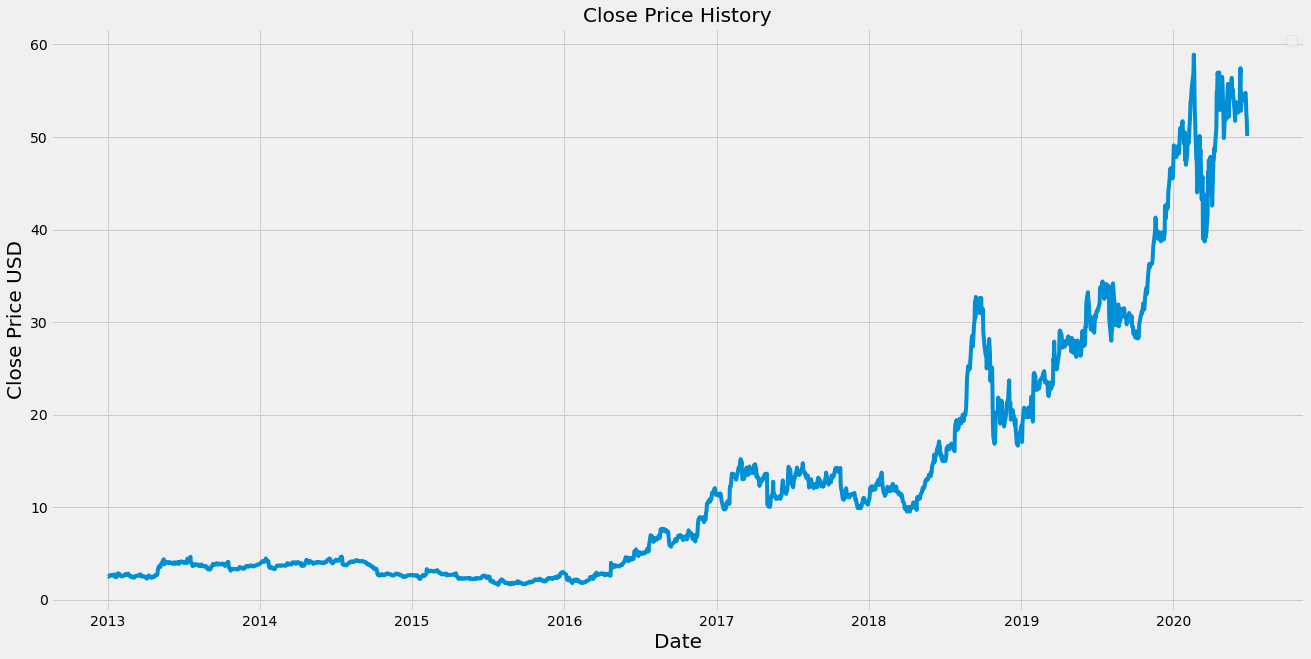

In [4]:
# Viaulize the price history of AMD stock
plt.figure(figsize=(20,10))
plt.title("Close Price History")
plt.plot(amd['Close'])
plt.xlabel('Date', fontsize=20)
plt.ylabel('Close Price USD', fontsize = 20)
plt.legend()
plt.show()


# Pre-processing the data before it goes into a model

In [5]:
# Clean the data to predict on the stock
# For it to run in a Keras Model the dataframe must be transformed to a numpy array

# The closing price will be the predictor so take only this column
amd_close = amd.filter(["Close"])
# Convert to numpy array
dataset = amd_close.values

# Scale the data
# This is necessary to preprocess the data to ensure the highs and lows (outliers) of the data are on the same scale
# This step is similar to image preprocessing image data when diving all pixels by 255
scaler = MinMaxScaler(feature_range=(0,1))
# This puts all data points either at a 0 or 1 or anything between
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.01588687],
       [0.01518855],
       [0.01693436],
       ...,
       [0.88634773],
       [0.87831702],
       [0.84636867]])

# Model

In [6]:
# training data set 
train = scaled_data[0:len(scaled_data), :]

# Split the training data

# The idea here is to take data out of the scaled dataset and apply them to two different list
# One list will be made up of the predictor variables while the other list will be made up of the prediction
# This split is necessary to train the model so that when a test set comes in, 
# we can fit this training data set to the test or any new stock data for AMD

# make x_train an empty list
# this will be the predictor variable
x_train = []
# make y_train an empty list
# make y_train as dependent variable 
y_train = []

for i in range(100, len(train)):
  # this takes the position of i to 100 but excludes i and 
  # appends to the x_train list
  # take the 0 column which means first column
  x_train.append(train[i-100:i, 0])
  y_train.append(train[i,0])

  if i <= 101:
    print(x_train)
    print(y_train)
    print()



[array([0.01588687, 0.01518855, 0.01693436, 0.01833101, 0.01833101,
       0.01763268, 0.0174581 , 0.01833101, 0.01780726, 0.01850559,
       0.01920391, 0.01955307, 0.0146648 , 0.01449022, 0.01937849,
       0.02042598, 0.02147346, 0.02094972, 0.01955307, 0.01798184,
       0.01710894, 0.01710894, 0.01571229, 0.01710894, 0.01710894,
       0.01658519, 0.01693436, 0.01833101, 0.02007681, 0.01972765,
       0.01972765, 0.01902933, 0.02094972, 0.01885475, 0.01710894,
       0.01728352, 0.01588687, 0.0146648 , 0.01588687, 0.01518855,
       0.01396648, 0.01361732, 0.01414106, 0.01414106, 0.01623603,
       0.01641061, 0.01693436, 0.01728352, 0.01710894, 0.01763268,
       0.01710894, 0.01798184, 0.01833101, 0.01972765, 0.01780726,
       0.01606145, 0.01553771, 0.01606145, 0.01623603, 0.01623603,
       0.01431564, 0.01344274, 0.01222067, 0.01239525, 0.01169693,
       0.01693436, 0.01763268, 0.01728352, 0.01571229, 0.01501397,
       0.01361732, 0.01431564, 0.01361732, 0.01553771, 0.0148

In [7]:
# Convert the training data set to numpy array for modeling
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshaping is necessary for LSTM which requires 3-dimensional data
# with a numpy array it will only be a 2-dimensional data set

# to check the shape
# Here it can be seen that 1785 rows and 100 columns
# To reshape to numpy array, the first position will be the number of rows
# The second position will be the number of columns (time steps)
# The third position will be the number of features which is 1 since its just the closing price
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1785, 100, 1)

In [8]:
# Build the LSTM model

model = Sequential()
# Add first layer
# First layer, 50 neurons, return_sequence = True since another layer will be added in after this
# on the input_shape the first [1] refers to the time steps
# the second 1 is features which is still 1, the closing price
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
# False this time as no LSTM layers being added
model.add(LSTM(50, return_sequences=False))
# Add a dense layer with 25 neurons
model.add(Dense(25))
# Add a dense layer with 1 neuron
model.add(Dense(1))

In [9]:
# Compiling the model 
# the loss function basically helps guide the optimizer in the right direction
# the optimizer ties in the model parameters to the loss function 

# Other optimizers to use
    #Gradient Descent
    #Adagrad
    #RMSprop

model.compile(optimizer = "adam", loss = "mean_squared_error")

# Model train
# Epochs are full runs through the data forward and back
model.fit(x_train, y_train, batch_size=1, epochs = 20)

Epoch 1/20
1785/1785 [==============================] - 98s 55ms/step - loss: 0.0023
Epoch 2/20
1785/1785 [==============================] - 95s 53ms/step - loss: 0.0010
Epoch 3/20
1785/1785 [==============================] - 96s 54ms/step - loss: 7.5471e-04
Epoch 4/20
1785/1785 [==============================] - 96s 54ms/step - loss: 5.0752e-04
Epoch 5/20
1785/1785 [==============================] - 96s 54ms/step - loss: 5.6868e-04
Epoch 6/20
1785/1785 [==============================] - 96s 54ms/step - loss: 4.0290e-04
Epoch 7/20
1785/1785 [==============================] - 96s 54ms/step - loss: 4.8932e-04
Epoch 8/20
1785/1785 [==============================] - 96s 54ms/step - loss: 4.2462e-04
Epoch 9/20
1785/1785 [==============================] - 99s 56ms/step - loss: 3.7605e-04
Epoch 10/20
1785/1785 [==============================] - 95s 53ms/step - loss: 4.7846e-04
Epoch 11/20
1785/1785 [==============================] - 95s 53ms/step - loss: 3.2676e-04
Epoch 12/20
1785/1785 [====

In [ ]:
# Create the Test data set
test = scaled_data[]